In [ ]:
!pip install category_encoders
!pip install xgboost
!pip install catboost

In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

1) predict bid/not bid as target variable
2) predict won/lost as target variable - only on the accepted ones (bid)

for bid/notbid - minimize false negatives  --> focus on recall
-- understand why bid or not bid
-- do SHAP value, also Tableau
won/lost --> f1 score

# I. Read dataset

In [ ]:
df_encoded=pd.read_csv('03_df_encoded_wonlost.csv', delimiter=',')
df_encoded.head()

,Amount_DE,Amount_HD,Amount_ID,Amount_OTHER,Amount_PP,Amount_PS,Amount_SP,Total_Amount,SR_codigo,Resolution_time,Client_type,Market_segment,Client_BU,Country,Client_importance,Coverage_model,Result_offer_binary
0,0.001945,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000718,0,0.078611,0.456166,1037,3473,1,3,6,0
1,0.002045,0.0,0.1,0.0,0.02803,0.020478,0.0,0.021526,1,0.235466,0.456166,137,2861,1,3,6,1
2,0.003382,0.0,0.0,0.0,0.00000,0.000005,0.0,0.001252,2,0.032176,0.456166,248,3473,1,3,6,0
3,0.003382,0.0,0.0,0.0,0.00000,0.000005,0.0,0.001252,3,0.025229,0.456166,248,3473,1,3,6,0
4,0.003382,0.0,0.0,0.0,0.00000,0.000005,0.0,0.001252,4,0.025229,0.456166,248,3473,1,3,6,0


In [ ]:
df_notdecided = pd.read_csv('/content/06_df_encoded_notdecided.csv', delimiter=',')
df_notdecided.head()

,Amount_DE,Amount_HD,Amount_ID,Amount_OTHER,Amount_PP,Amount_PS,Amount_SP,Total_Amount,SR_codigo,Resolution_time,Client_type,Market_segment,Client_BU,Country,Client_importance,Coverage_model
0,0.000000e+00,0.0,0.000000,0.0012,0.0,0.000000,0.0,1.006678e-04,SR-3449381,0.024497,0.456166,0.0,7.0,1,1.0,6
1,9.090909e-09,0.0,0.000000,0.0000,0.0,0.000000,0.0,3.355592e-09,SR-3449749,0.024497,0.713579,0.0,55.0,1,3.0,6
2,0.000000e+00,0.0,0.000000,0.0000,0.0,0.000027,0.0,1.677796e-05,SR-3449844,0.024497,0.713579,0.0,33.0,1,0.0,2
3,2.727273e-05,0.0,0.000188,0.0000,0.0,0.000000,0.0,2.013355e-05,SR-3465617,0.024497,0.534211,36.0,35.0,1,1.0,1
4,1.818182e-05,0.0,0.000000,0.0000,0.0,0.000000,0.0,6.711184e-06,SR-3511658,0.024497,0.456166,18.0,55.0,1,2.0,2


# II. ML models Training

## 1. Split

In [ ]:
# Define predictors (X) and target (y)
X = df_encoded.drop(columns=['Result_offer_binary', 'SR_codigo'])
y = df_encoded['Result_offer_binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

## 2. Training

### XGBoost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:00:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.62      0.68      2166
           1       0.77      0.87      0.81      3141

    accuracy                           0.77      5307
   macro avg       0.77      0.74      0.75      5307
weighted avg       0.77      0.77      0.76      5307


Accuracy: 0.7665347654041832

ROC AUC Score: 0.8148122425737931

Confusion Matrix:
[[1343  823]
 [ 416 2725]]


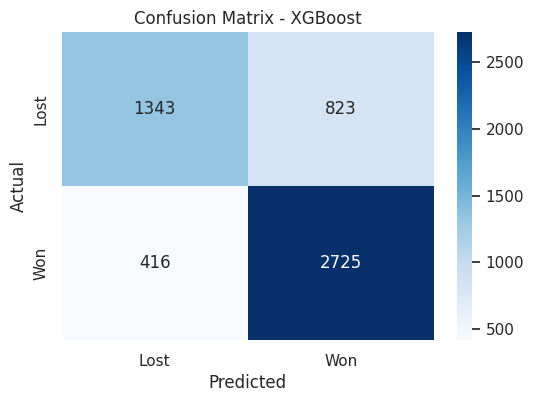

In [ ]:
#XGBoost

# Train an XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
xgb_predictions = xgb_model.predict(X_test)
xgb_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for ROC AUC

# Classification Report
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

# Accuracy
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("\nAccuracy:", xgb_accuracy)

# ROC AUC Score
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_prob)
print("\nROC AUC Score:", xgb_roc_auc)

# Confusion Matrix
xgb_cm = confusion_matrix(y_test, xgb_predictions)
print("\nConfusion Matrix:")
print(xgb_cm)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Lost', 'Won'], yticklabels=['Lost', 'Won'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

### Catboost

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.56      0.65      2166
           1       0.75      0.89      0.81      3141

    accuracy                           0.76      5307
   macro avg       0.77      0.73      0.73      5307
weighted avg       0.76      0.76      0.75      5307


Accuracy: 0.7579
ROC AUC Score: 0.8173

Confusion Matrix:
[[1219  947]
 [ 338 2803]]


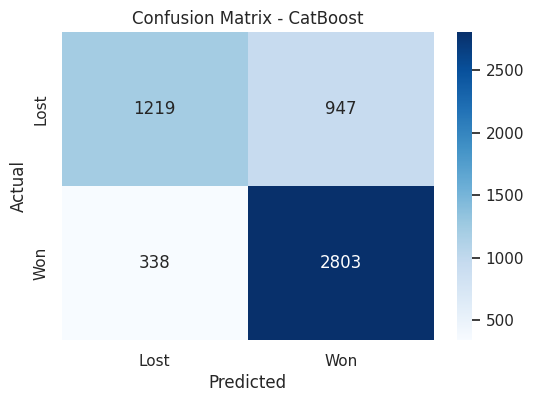

In [ ]:
#Catboost

# Initialize and train CatBoost Classifier
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)

# Predict on the test set
catboost_predictions = catboost_model.predict(X_test)
catboost_pred_prob = catboost_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for ROC AUC

# Evaluate the model
print("CatBoost Classification Report:")
print(classification_report(y_test, catboost_predictions))

# Accuracy
accuracy = catboost_model.score(X_test, y_test)
print(f"\nAccuracy: {accuracy:.4f}")

# ROC AUC Score
roc_auc = roc_auc_score(y_test, catboost_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
catboost_cm = confusion_matrix(y_test, catboost_predictions)
print("\nConfusion Matrix:")
print(catboost_cm)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(catboost_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Lost', 'Won'], yticklabels=['Lost', 'Won'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CatBoost')
plt.show()


# III. Performance comparison

In [ ]:
#Performance comparison

# Example list of models and their predictions (replace these with your actual models and predictions)
models = {
    "XGBoost": (xgb_model, xgb_predictions, xgb_pred_prob),
    "CatBoost": (catboost_model, catboost_predictions, catboost_pred_prob),
}

# Store metrics for each model
results = {
    "Model": [],
    "Accuracy": [],
    "ROC AUC": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Loop through models and calculate metrics
for model_name, (model, predictions, pred_prob) in models.items():
    accuracy = accuracy_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, pred_prob)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    # Append results
    results["Model"].append(model_name)
    results["Accuracy"].append(accuracy)
    results["ROC AUC"].append(roc_auc)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1-Score"].append(f1)

# Convert to DataFrame for display
results_df = pd.DataFrame(results)

# Print results
print("Model Performance Metrics:")
print(results_df)

# Optional: Save to CSV
# results_df.to_csv('model_performance_metrics.csv', index=False)


Model Performance Metrics:
      Model  Accuracy   ROC AUC  Precision    Recall  F1-Score
0   XGBoost  0.766535  0.814812   0.768038  0.867558  0.814771
1  CatBoost  0.757867  0.817317   0.747467  0.892391  0.813525


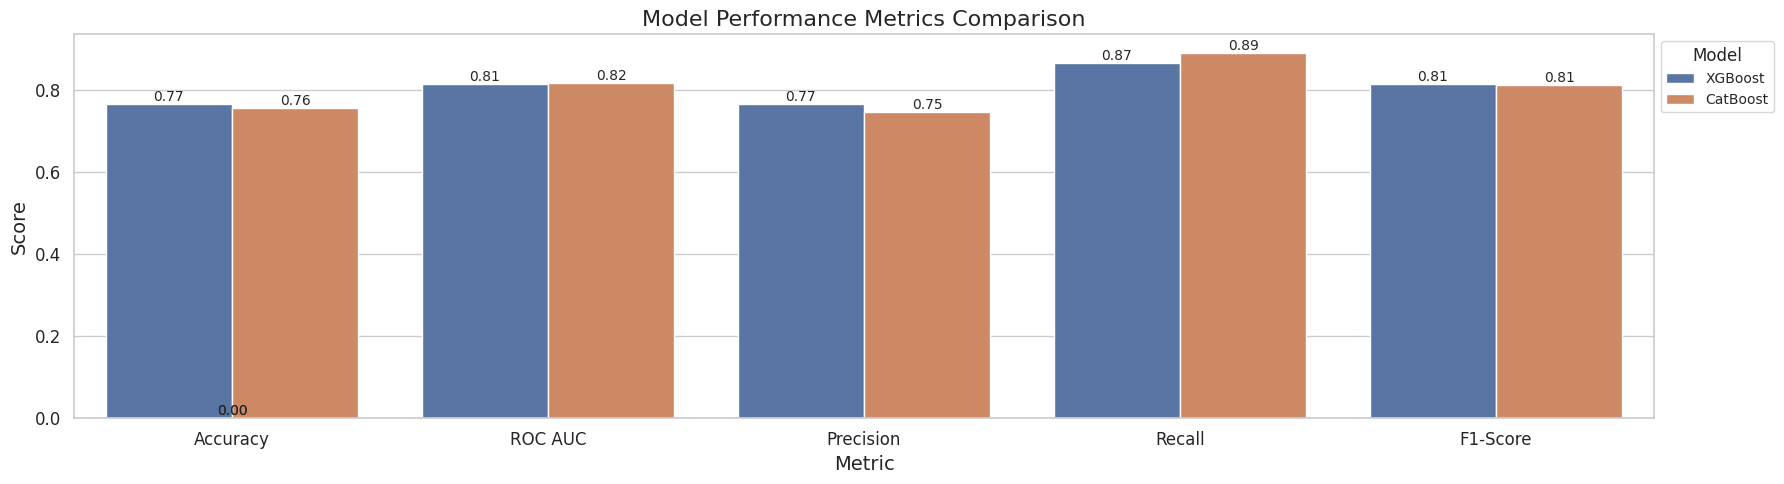

In [ ]:
#Performance comparison

# Sort results_df by Accuracy in descending order
results_df_sorted = results_df.sort_values(by="Accuracy", ascending=False)

# Melt the DataFrame for visualization
results_melted = results_df_sorted.melt(id_vars=["Model"],
                                        var_name="Metric",
                                        value_name="Score")

# Set up the figure size and style
plt.figure(figsize=(18, 5))
sns.set(style="whitegrid")

# Create a barplot
ax = sns.barplot(data=results_melted, x="Metric", y="Score", hue="Model", order=["Accuracy", "ROC AUC", "Precision", "Recall", "F1-Score"])

# Add numbers above the bars
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center', size=10, xytext=(0, 5),
                textcoords='offset points')

# Add labels and title
plt.title("Model Performance Metrics Comparison", fontsize=16)
plt.xlabel("Metric", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust legend position
plt.legend(title="Model", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.tight_layout()
plt.show()


# IV. Feature importance

## 1. Feature Importance

<ipython-input-110-f674fe8474cb>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance, palette="viridis")


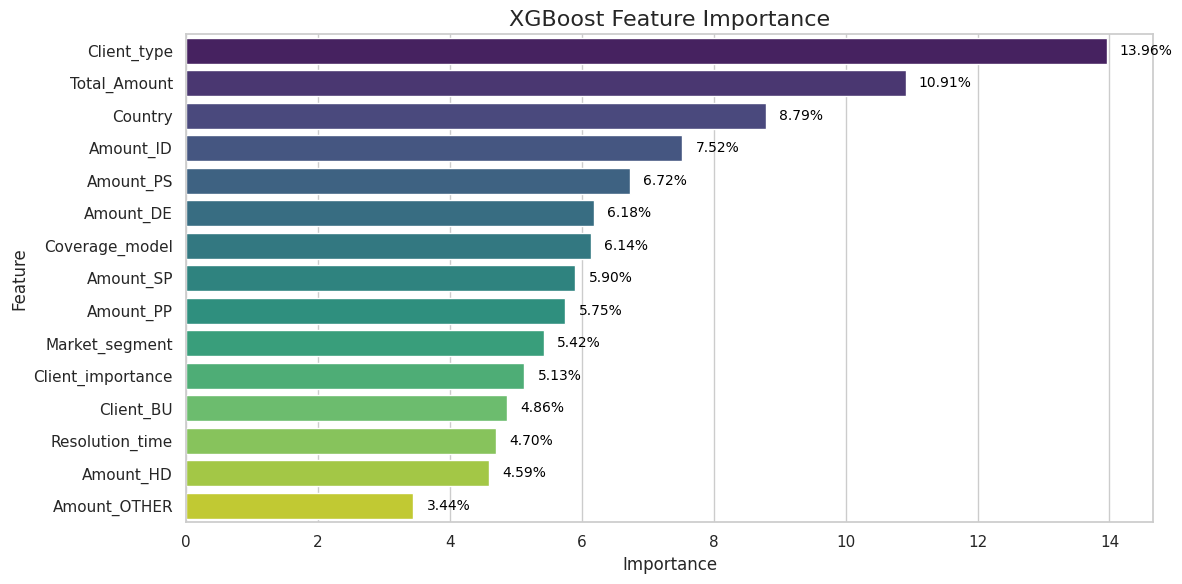

In [ ]:
#XGBoost

# Get feature importance
xgb_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Normalize feature importances to percentages
xgb_feature_importance['Importance'] = (
    xgb_feature_importance['Importance'] * 100
)

# Plot feature importance
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance, palette="viridis")

# Add annotations for the importance values as percentages
for patch, importance in zip(barplot.patches, xgb_feature_importance['Importance']):
    plt.text(
        x=patch.get_width() + 0.2,  # Position slightly to the right of the bar
        y=patch.get_y() + patch.get_height() / 2,  # Center vertically in the bar
        s=f"{importance:.2f}%",  # Format the importance value as a percentage with 2 decimal places
        va="center",  # Center vertically
        fontsize=10,  # Font size for the annotation
        color="black"  # Color of the text
    )

# Customize the plot
plt.title("XGBoost Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-111-d3b3429f787e>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Importance', y='Feature', data=catboost_feature_importance, palette="viridis")


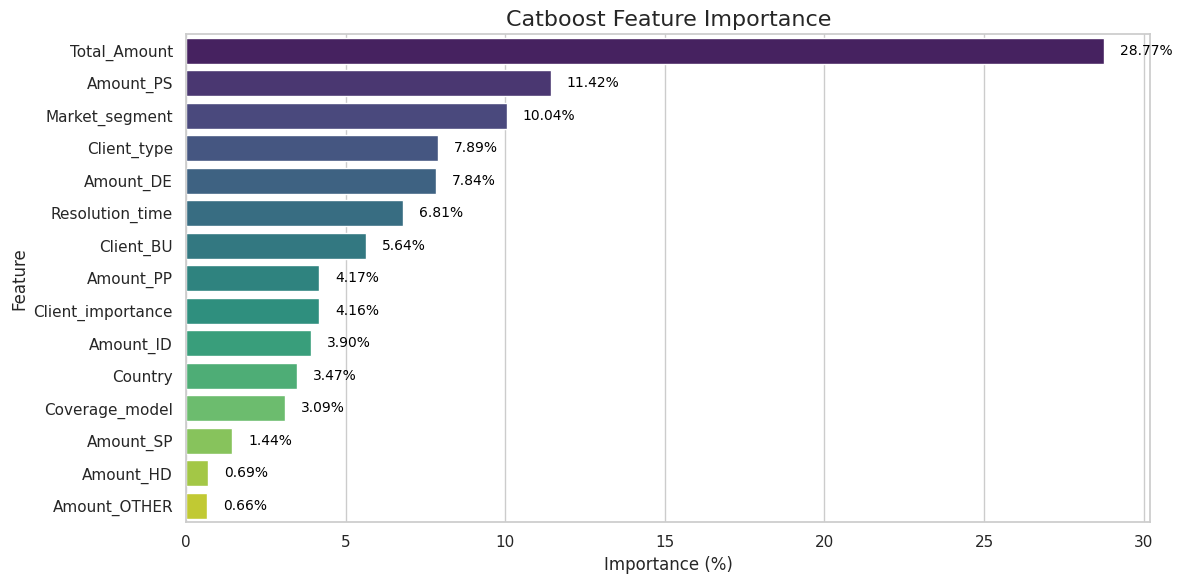

In [ ]:
#Catboost

# Get feature importance
catboost_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': catboost_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Normalize feature importances to percentages
catboost_feature_importance['Importance'] = (
    catboost_feature_importance['Importance'] / catboost_feature_importance['Importance'].sum() * 100
)

# Plot feature importance
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Importance', y='Feature', data=catboost_feature_importance, palette="viridis")

# Add annotations for the importance values as percentages
for patch, importance in zip(barplot.patches, catboost_feature_importance['Importance']):
    plt.text(
        x=patch.get_width() + 0.5,  # Position slightly to the right of the bar
        y=patch.get_y() + patch.get_height() / 2,  # Center vertically in the bar
        s=f"{importance:.2f}%",  # Format the importance value as a percentage with 2 decimal places
        va="center",  # Center vertically
        fontsize=10,  # Font size for the annotation
        color="black"  # Color of the text
    )

# Customize the plot
plt.title("Catboost Feature Importance", fontsize=16)
plt.xlabel("Importance (%)", fontsize=12)  # Update the label to reflect percentages
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Feature Importance:

# Print top features for each model

print("\nXGBoost Top Features:")
print(xgb_feature_importance.head())

print("\nCatboost Top Features:")
print(catboost_feature_importance.head())




XGBoost Top Features:
         Feature  Importance
9    Client_type   13.957521
7   Total_Amount   10.908864
12       Country    8.788944
2      Amount_ID    7.521594
5      Amount_PS    6.724773

Catboost Top Features:
           Feature  Importance
7     Total_Amount   28.771943
5        Amount_PS   11.418841
10  Market_segment   10.042963
9      Client_type    7.891202
0        Amount_DE    7.837107


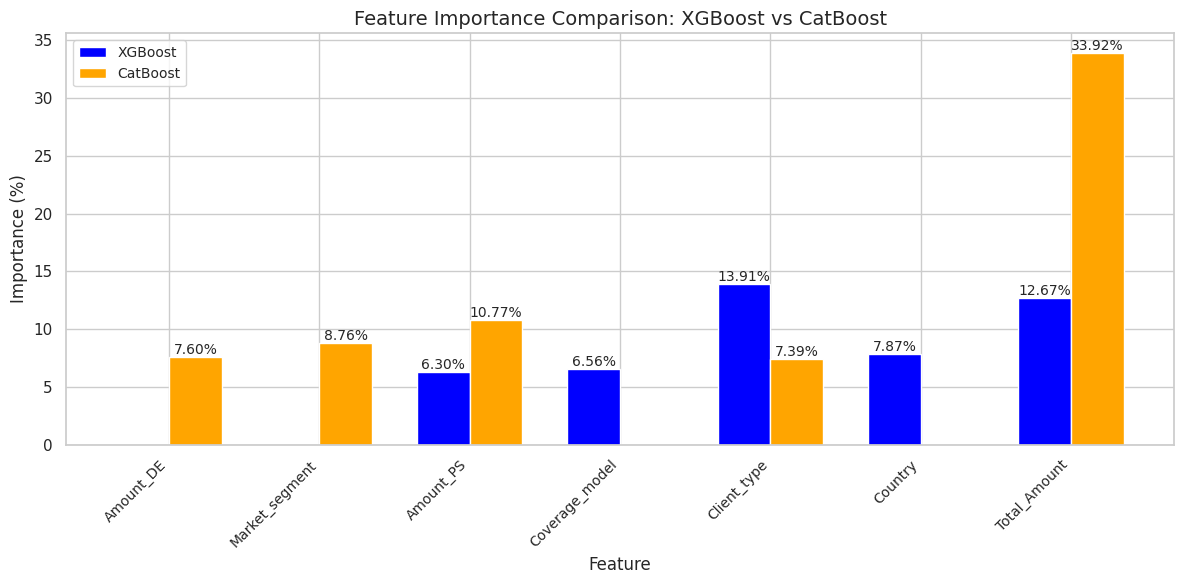

In [ ]:
# Visualize Feature Importance Across Models. To visually compare the feature importance rankings
#Workaround so results are comparable

# XGBoost and CatBoost feature importance data
xgb_importance = {
    'Feature': ['Client_type', 'Total_Amount', 'Country', 'Coverage_model', 'Amount_PS'],
    'Importance': [13.913745, 12.665617, 7.871514, 6.560954, 6.304859]
}

cb_importance = {
    'Feature': ['Total_Amount', 'Amount_PS', 'Market_segment', 'Amount_DE', 'Client_type'],
    'Importance': [33.916204, 10.770068, 8.763733, 7.603841, 7.393445]
}

# Convert dictionaries to DataFrames
xgb_df = pd.DataFrame(xgb_importance)
cb_df = pd.DataFrame(cb_importance)

# Combine data for comparison
all_features = set(xgb_df['Feature']).union(cb_df['Feature'])
combined_df = pd.DataFrame({'Feature': list(all_features)})

# Merge the feature importance values
combined_df = combined_df.merge(xgb_df, on='Feature', how='left', suffixes=('', '_XGB'))
combined_df = combined_df.merge(cb_df, on='Feature', how='left', suffixes=('', '_CB'))

# Fill missing values with 0 (for features not present in both models)
combined_df = combined_df.fillna(0)

# Rename columns for clarity
combined_df.columns = ['Feature', 'XGBoost Importance', 'CatBoost Importance']

# Plotting the comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each model
width = 0.35  # Bar width
x = np.arange(len(combined_df['Feature']))
xgb_bars = ax.bar(x - width/2, combined_df['XGBoost Importance'], width, label='XGBoost', color='blue')
cb_bars = ax.bar(x + width/2, combined_df['CatBoost Importance'], width, label='CatBoost', color='orange')

# Add numbers above the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only add labels for non-zero heights
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.2f}%",  # Format as percentage
                ha='center',
                va='bottom',
                fontsize=10
            )

add_labels(xgb_bars)
add_labels(cb_bars)

# Formatting the chart
ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('Importance (%)', fontsize=12)  # Adjusted for percentage display
ax.set_title('Feature Importance Comparison: XGBoost vs CatBoost', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(combined_df['Feature'], rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


## 2. SHAP values

SHAP Values (SHapley Additive exPlanations)

SHAP is one of the most robust methods to explain feature importance. It shows the impact of each feature on individual predictions.

    SHAP values provide a game-theoretic approach to explaining the output of machine learning models.
    They show the contribution of each feature to the prediction for individual samples.


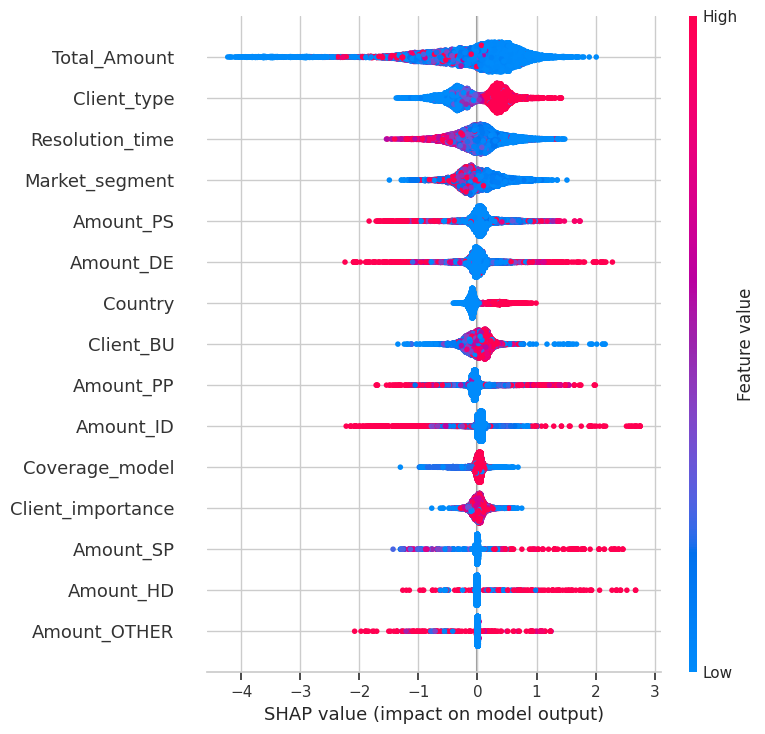

In [ ]:
#XG Boost

import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(xgb_model)  # Replace xgb_model with your trained model
shap_values = explainer.shap_values(X)

# Plot the summary of feature contributions
shap.summary_plot(shap_values, X)


This SHAP summary plot reveals:

The relative importance of features (Total_Amount and Client_type are the most influential).
How specific feature values (high or low) drive predictions positively or negatively.

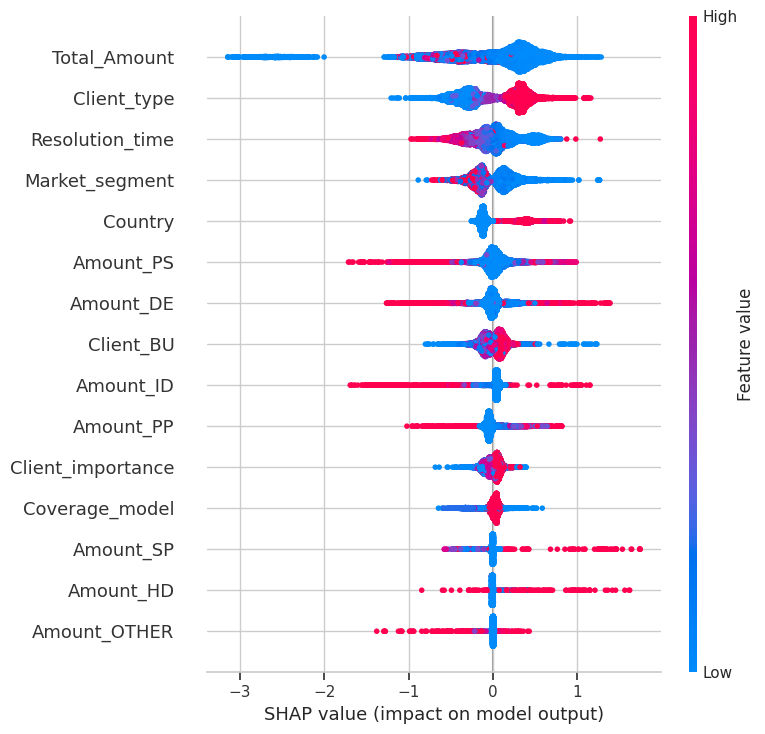

In [ ]:
#CATBoost

import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X)

# Plot the summary of feature contributions
shap.summary_plot(shap_values, X)


## 3. Permutation importance
Permutation importance measures the impact of each feature on the model's performance by randomly shuffling its values and observing how much the model’s performance decreases as a result. A larger decrease in performance indicates higher importance for that feature.
It helps confirm whether the features identified as important by the model are truly significant.

Key Points in the Plot:
X-Axis (Permutation Importance):

Represents how much the model’s performance decreases when a specific feature is shuffled (rendering it random).
Higher values indicate greater importance because shuffling that feature significantly disrupts the model’s predictions.
Y-Axis (Features):

Lists the features in order of importance, with the most important feature at the top.


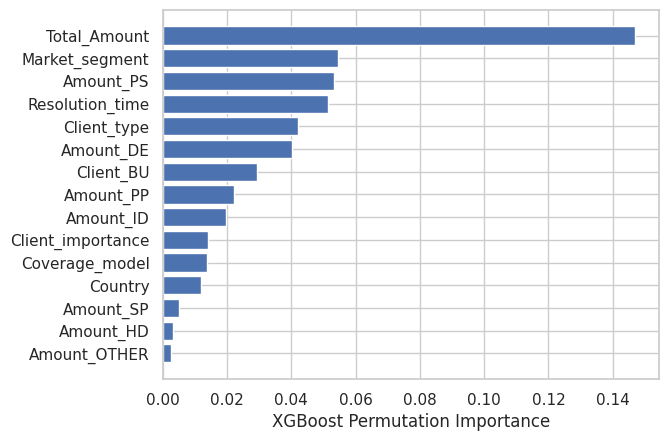

In [ ]:
#XGBoost

# Calculate permutation importance
perm_importance = permutation_importance(xgb_model, X, y, n_repeats=10, random_state=42)

# Plot permutation importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("XGBoost Permutation Importance")
plt.show()


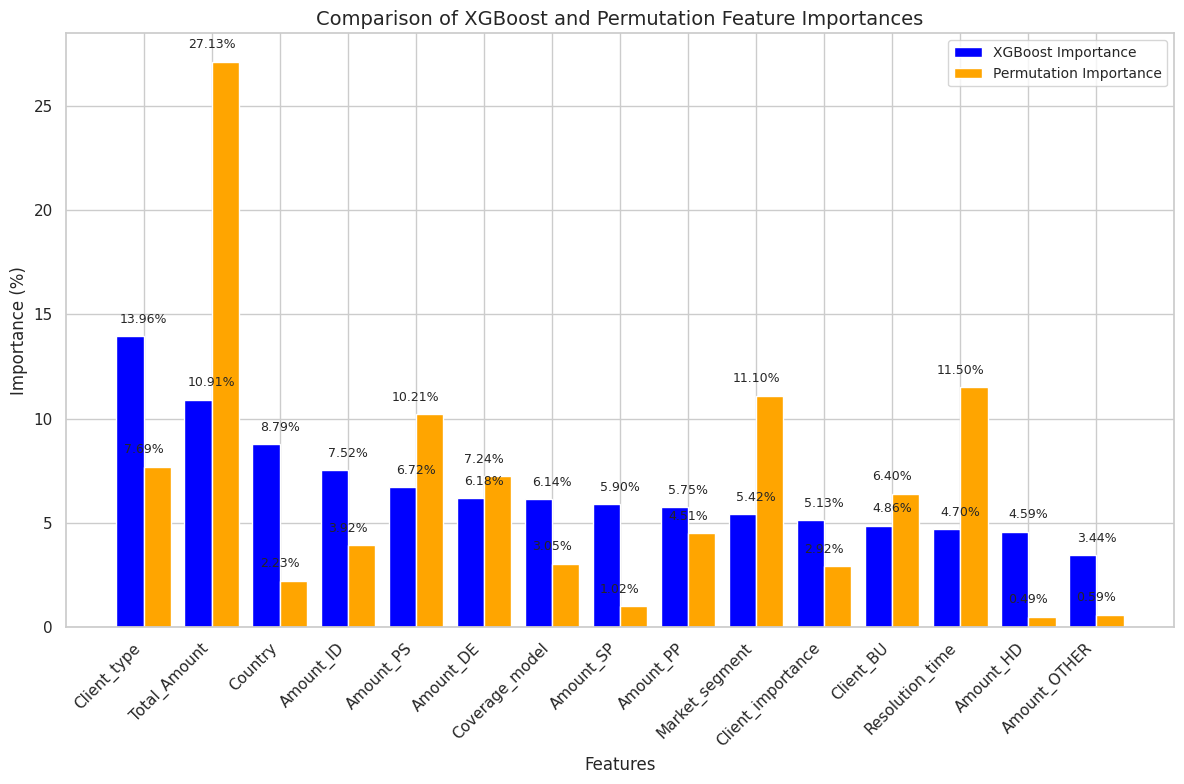

In [ ]:
from sklearn.inspection import permutation_importance

# Assume X_train, y_train, and xgb_model are already defined
# X_train: training features
# y_train: target variable
# xgb_model: trained XGBoost model

# Get XGBoost feature importance
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'XGBoost Importance': xgb_model.feature_importances_
})

# Normalize XGBoost importance values
xgb_importance['XGBoost Importance'] = (
    xgb_importance['XGBoost Importance'] / xgb_importance['XGBoost Importance'].sum()
) * 100

# Calculate permutation importance
perm_importance = permutation_importance(xgb_model, X_train, y_train, scoring='accuracy', random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Permutation Importance': perm_importance['importances_mean']
})

# Normalize permutation importance values
perm_importance_df['Permutation Importance'] = (
    perm_importance_df['Permutation Importance'] / perm_importance_df['Permutation Importance'].sum()
) * 100

# Merge the two importance metrics
comparison_df = pd.merge(
    xgb_importance, perm_importance_df, on='Feature', how='outer'
).fillna(0)  # Fill missing values with 0 for features not found in both methods

# Sort by XGBoost Importance
comparison_df = comparison_df.sort_values(by='XGBoost Importance', ascending=False)

# Plot the comparison
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.4
x = np.arange(len(comparison_df['Feature']))

# Plot XGBoost Importance
ax.bar(x - width/2, comparison_df['XGBoost Importance'], width, label='XGBoost Importance', color='blue')

# Plot Permutation Importance
ax.bar(x + width/2, comparison_df['Permutation Importance'], width, label='Permutation Importance', color='orange')

# Add labels to bars
for bars in [comparison_df['XGBoost Importance'], comparison_df['Permutation Importance']]:
    for bar, height in zip(x, bars):
        ax.text(
            bar,
            height + 0.5,
            f"{height:.2f}%",
            ha='center',
            va='bottom',
            fontsize=9
        )

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Feature'], rotation=45, ha='right')
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Importance (%)', fontsize=12)
ax.set_title('Comparison of XGBoost and Permutation Feature Importances', fontsize=14)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


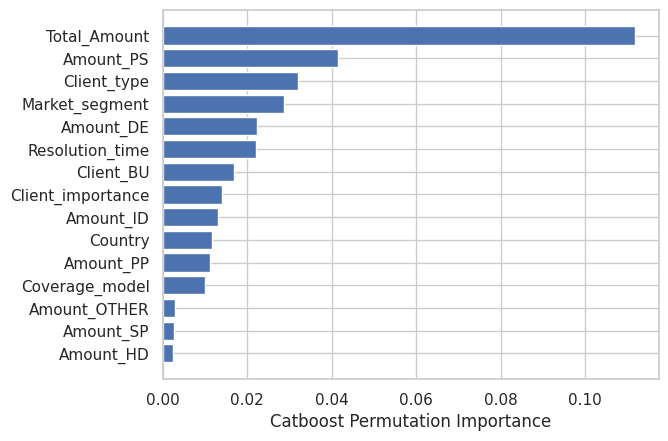

In [ ]:
#Catboost

# Calculate permutation importance
perm_importance = permutation_importance(catboost_model, X, y, n_repeats=10, random_state=42)

# Plot permutation importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Catboost Permutation Importance")
plt.show()


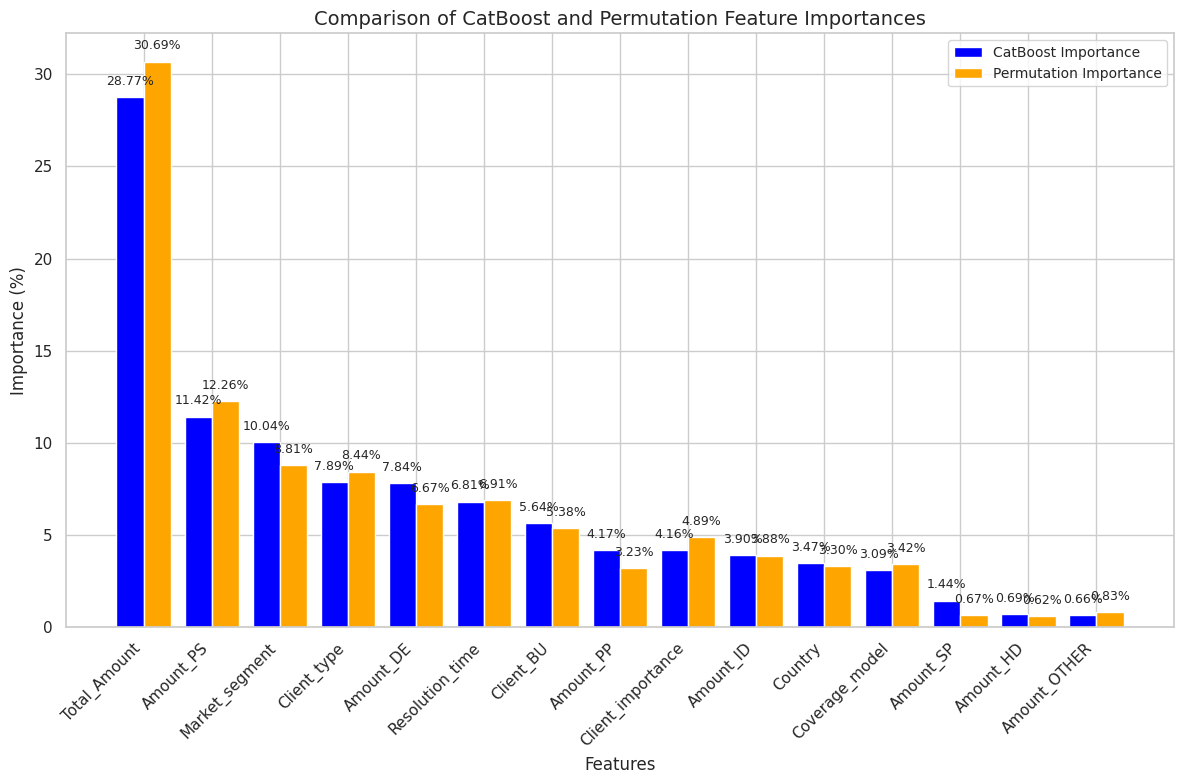

In [ ]:
from sklearn.inspection import permutation_importance

# Assume X_train, y_train, and catboost_model are already defined
# X_train: training features
# y_train: target variable
# catboost_model: trained CatBoost model

# Get CatBoost feature importance
catboost_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'CatBoost Importance': catboost_model.get_feature_importance()
})

# Normalize CatBoost importance values
catboost_importance['CatBoost Importance'] = (
    catboost_importance['CatBoost Importance'] / catboost_importance['CatBoost Importance'].sum()
) * 100

# Calculate permutation importance
perm_importance = permutation_importance(catboost_model, X_train, y_train, scoring='accuracy', random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Permutation Importance': perm_importance['importances_mean']
})

# Normalize permutation importance values
perm_importance_df['Permutation Importance'] = (
    perm_importance_df['Permutation Importance'] / perm_importance_df['Permutation Importance'].sum()
) * 100

# Merge the two importance metrics
comparison_df = pd.merge(
    catboost_importance, perm_importance_df, on='Feature', how='outer'
).fillna(0)  # Fill missing values with 0 for features not found in both methods

# Sort by CatBoost Importance
comparison_df = comparison_df.sort_values(by='CatBoost Importance', ascending=False)

# Plot the comparison
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.4
x = np.arange(len(comparison_df['Feature']))

# Plot CatBoost Importance
ax.bar(x - width/2, comparison_df['CatBoost Importance'], width, label='CatBoost Importance', color='blue')

# Plot Permutation Importance
ax.bar(x + width/2, comparison_df['Permutation Importance'], width, label='Permutation Importance', color='orange')

# Add labels to bars
def add_labels(bars, values):
    for bar, value in zip(bars, values):
        ax.text(
            bar,
            value + 0.5,
            f"{value:.2f}%",
            ha='center',
            va='bottom',
            fontsize=9
        )

add_labels(x - width/2, comparison_df['CatBoost Importance'])
add_labels(x + width/2, comparison_df['Permutation Importance'])

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Feature'], rotation=45, ha='right')
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Importance (%)', fontsize=12)
ax.set_title('Comparison of CatBoost and Permutation Feature Importances', fontsize=14)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


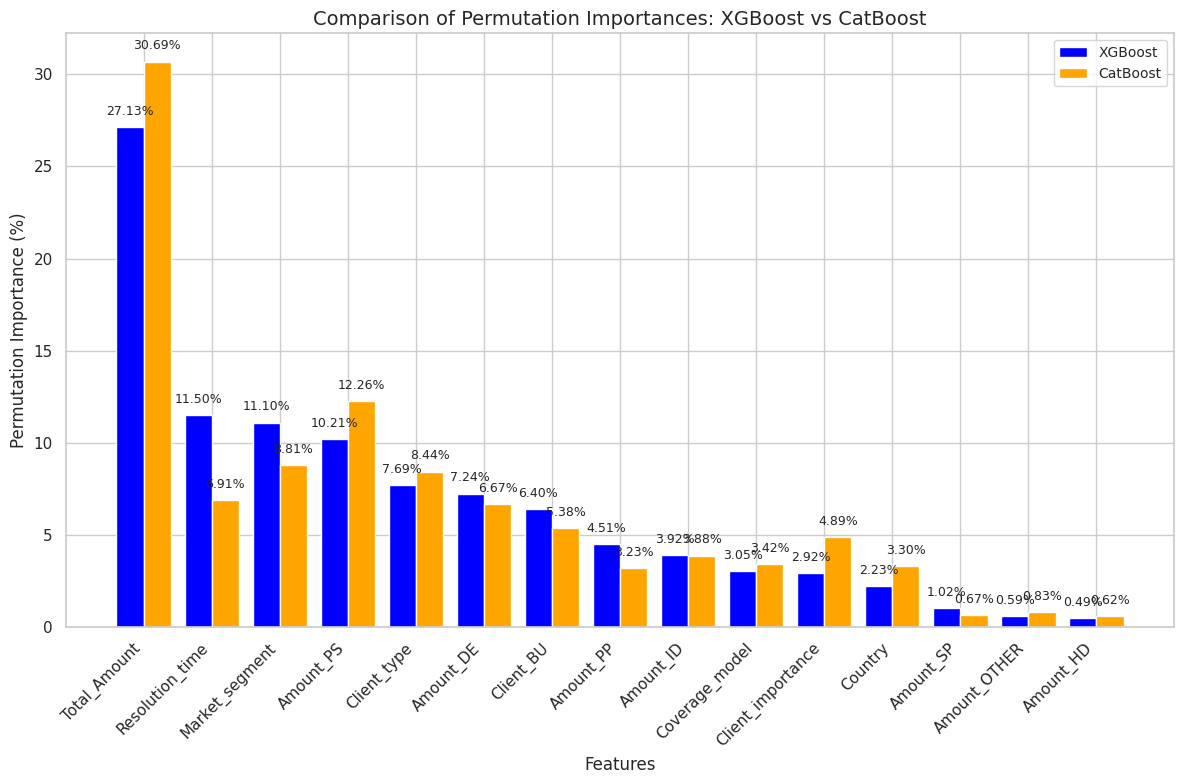

In [ ]:
from sklearn.inspection import permutation_importance

# Assume X_train, y_train, xgb_model, and catboost_model are already defined

# Calculate permutation importance for XGBoost
xgb_perm_importance = permutation_importance(
    xgb_model, X_train, y_train, scoring='accuracy', random_state=42
)
xgb_perm_df = pd.DataFrame({
    'Feature': X_train.columns,
    'XGBoost Permutation Importance': xgb_perm_importance['importances_mean']
})

# Calculate permutation importance for CatBoost
catboost_perm_importance = permutation_importance(
    catboost_model, X_train, y_train, scoring='accuracy', random_state=42
)
catboost_perm_df = pd.DataFrame({
    'Feature': X_train.columns,
    'CatBoost Permutation Importance': catboost_perm_importance['importances_mean']
})

# Normalize permutation importance values for both models
xgb_perm_df['XGBoost Permutation Importance'] = (
    xgb_perm_df['XGBoost Permutation Importance'] / xgb_perm_df['XGBoost Permutation Importance'].sum()
) * 100

catboost_perm_df['CatBoost Permutation Importance'] = (
    catboost_perm_df['CatBoost Permutation Importance'] / catboost_perm_df['CatBoost Permutation Importance'].sum()
) * 100

# Merge the results for comparison
comparison_df = pd.merge(
    xgb_perm_df, catboost_perm_df, on='Feature', how='outer'
).fillna(0)  # Fill missing values with 0 for features not found in both models

# Sort by XGBoost Permutation Importance for a consistent order
comparison_df = comparison_df.sort_values(by='XGBoost Permutation Importance', ascending=False)

# Plot the comparison
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.4
x = np.arange(len(comparison_df['Feature']))

# Plot XGBoost Permutation Importance
ax.bar(x - width/2, comparison_df['XGBoost Permutation Importance'], width, label='XGBoost', color='blue')

# Plot CatBoost Permutation Importance
ax.bar(x + width/2, comparison_df['CatBoost Permutation Importance'], width, label='CatBoost', color='orange')

# Add labels to bars
def add_labels(bars, values):
    for bar, value in zip(bars, values):
        ax.text(
            bar,
            value + 0.5,
            f"{value:.2f}%",
            ha='center',
            va='bottom',
            fontsize=9
        )

add_labels(x - width/2, comparison_df['XGBoost Permutation Importance'])
add_labels(x + width/2, comparison_df['CatBoost Permutation Importance'])

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Feature'], rotation=45, ha='right')
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Permutation Importance (%)', fontsize=12)
ax.set_title('Comparison of Permutation Importances: XGBoost vs CatBoost', fontsize=14)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


# VI. Prediction of Bid Not Decided Yet

In [ ]:
# Create a dictionary to encode 'SR- codigo'
unique_values = df_notdecided['SR_codigo'].unique()
sr_codigo_encoder = {value: idx for idx, value in enumerate(unique_values)}

# Replace the values in the 'SR- codigo' column with their encoded values
df_notdecided['SR_codigo'] = df_notdecided['SR_codigo'].map(sr_codigo_encoder)

# Print the encoded dictionary for reference
print("Encoded values stored in the dictionary:")
for key, value in sr_codigo_encoder.items():
    print(f"{key}: {value}")

Encoded values stored in the dictionary:
SR-3449381: 0
SR-3449749: 1
SR-3449844: 2
SR-3465617: 3
SR-3511658: 4
SR-3512108: 5
SR-3525229: 6
SR-3530438: 7
SR-3532120: 8
SR-3534329: 9
SR-3536231: 10
SR-3551045: 11
SR-3551362: 12
SR-3555297: 13
SR-3558579: 14
SR-3562072: 15
SR-3562780: 16
SR-3562990: 17
SR-3563703: 18
SR-3565649: 19
SR-3567580: 20
SR-3568043: 21
SR-3568100: 22
SR-3568160: 23
SR-3568906: 24
SR-3577794: 25
SR-3577952: 26
SR-3578327: 27
SR-3578764: 28
SR-3578864: 29
SR-3579822: 30
SR-3580365: 31
SR-3580712: 32
SR-3580734: 33
SR-3580736: 34
SR-3580739: 35
SR-3580741: 36
SR-3581461: 37
SR-3581628: 38
SR-3582372: 39
SR-3583988: 40
SR-3584172: 41
SR-3585460: 42
SR-3585495: 43
SR-3585797: 44
SR-3586131: 45
SR-3586858: 46
SR-3587350: 47
SR-3587470: 48
SR-3587783: 49
SR-3587866: 50
SR-3587871: 51
SR-3588908: 52
SR-3589139: 53
SR-3589521: 54
SR-3590200: 55
SR-3590352: 56
SR-3590458: 57
SR-3590711: 58
SR-3590730: 59
SR-3590818: 60
SR-3591812: 61
SR-3592089: 62
SR-3592186: 63
SR-359221

# VI. Prediction

In [ ]:
X_new_data = df_notdecided.drop(columns=['SR_codigo', 'Predicted_Probability_Won']) # Drop 'Predicted_Probability_Won'

# Make predictions
notdecided_predictions = xgb_model.predict_proba(X_new_data)[:, 1]  # Probability of "Won"

df_notdecided['Predicted_Probability_Won'] = notdecided_predictions

# Display the first few rows with predictions
print(df_notdecided.head())

      Amount_DE  Amount_HD  Amount_ID  Amount_OTHER  Amount_PP  Amount_PS  \
0  0.000000e+00        0.0   0.000000        0.0012        0.0   0.000000   
1  9.090909e-09        0.0   0.000000        0.0000        0.0   0.000000   
2  0.000000e+00        0.0   0.000000        0.0000        0.0   0.000027   
3  2.727273e-05        0.0   0.000188        0.0000        0.0   0.000000   
4  1.818182e-05        0.0   0.000000        0.0000        0.0   0.000000   

   Amount_SP  Total_Amount  SR_codigo  Resolution_time  Client_type  \
0        0.0  1.006678e-04          0         0.024497     0.456166   
1        0.0  3.355592e-09          1         0.024497     0.713579   
2        0.0  1.677796e-05          2         0.024497     0.713579   
3        0.0  2.013355e-05          3         0.024497     0.534211   
4        0.0  6.711184e-06          4         0.024497     0.456166   

   Market_segment  Client_BU  Country  Client_importance  Coverage_model  \
0             0.0        7.0      

In [ ]:
# Reverse the encoding dictionary
sr_codigo_decoder = {v: k for k, v in sr_codigo_encoder.items()}

# Decode the 'SR- codigo' column
df_notdecided['SR_codigo'] = df_notdecided['SR_codigo'].map(sr_codigo_decoder)

# Print the first few rows to confirm decodingprint(df_notdecided[['SR- codigo']].head())

In [ ]:
#Export to CSV
df_notdecided.to_csv('07_df_notdecided_predicted.csv', index=False)